### First Convergence Bias

In my post [Skill vs Strategy](http://www.r2rt.com/posts/meditations/2016-01-23-skill-vs-strategy/) I made the following proposition:

> Let’s say we retrain the network one million times, and each of the local minima reached leads to approximately the same performance. Is this enough for us to conclude that the resulting strategies are close to the best? I would answer in the negative; we cannot be certain that a random initialization will ever lead to an optimal strategy via backpropagation. It may be a situation like the chest shot, where in order to reach an optimal strategy, the network must be trained again after it has learned some useful hidden features.

In this post, I offer the results of an experiment providing support for this proposition. The specific experiment was not designed to test this proposition, and in fact, the results I obtained are opposite of the results I expected. 

### Motivation

In my post [Representational Power of Deeper Layers](http://www.r2rt.com/posts/experiments/2016-03-30-representational-power-of-deeper-layers/), I showed that progressively deeper layers serve as better representations of the original data. This motivated the thought that the better the first layer representation of the data, the better the last layer representation could be. Intuitively, this makes sense, if our first layer can get us 95% of the way to the best solution, then the second layer only has 5% of ground to cover, whereas if the first layer only gets 70% of the way there, the second layer has six times as much work to do. 

### Experiment

I tested this hypothesis by setting up a neural network with 3-hidden layers to classify MNIST digits. The network is trained only on 1000 MNIST training examples, as opposed to the entire training set of 50000, and achieves a test accuracy of between 86% and 89%.

Using a simple mini-batch gradient descent with a batch-size of 50, I compared the following two scenarios:

1. Training the entire network for 1000 steps. 
2. Training the first layer for 200 steps, training the first and second layers together for 200 steps, and only then training the entire network for 1000 steps. 

My hypothesis was that the second option would lead to better results, because by the time the third layer starts training, the first and second layers are finely tuned to produce "good" representations of the data. This hypothesis was proven incorrect. 

### Results

For each of the two training strategies above, I trained 500 randomly-initialized networks and recorded their final accuracies. Training the entire network at once yielded an average test accuracy of 87.87%, whereas training the two earlier layers before training the entire network yielded an average test accuracy of only 87.64%. While this is not that significant of a difference, the plot below clearly shows that the "local minima" that each strategy reaches is pulled from a different distribution. 

### Discussion

Although my hypothesis was invalidated, the result is nice because it supports my prior proposition that the local minima of first convergence may be biased. I.e., we have no guarantee of getting to the best local minima after training via backpropagation. Thus, the discussion in [Skill vs Strategy](http://www.r2rt.com/posts/meditations/2016-01-23-skill-vs-strategy/) is very relevant. Convergence speed aside, which is the usual reason for preferring alternate training strategies, other training strategies (e.g., other optimization strategies like Adagrad) are worth exploring as they might be biased toward a superior quality of local minima. 

How this relates to "greedy layer-wise training of deep networks" (see [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf)) may also be interesting. I haven't learned enough yet to dive into that paper or that method of training, but the gist, as I currently understand it, is that we can obtain better initializations of the weights in a deep network by first training each layer in an unsupervised fashion. In this experiment I did greedy layer-wise *supervised* training, which led to worse results. As an aside, the discussion in that paper also strongly supports the proposition that local minima of first convergence may be biased. 

### Code

In [1]:
import tensorflow as tf
import numpy as np
import load_mnist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
mnist = load_mnist.read_data_sets('MNIST_data', one_hot=True)

/home/silviu/anaconda3/lib/python3.5/gzip.py:274: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._buffer.read(size)
/home/silviu/Dropbox/pyml/TF/load_mnist.py:52: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def simple_fc_layer(input_layer, shape):
    w = weight_variable(shape)
    b = bias_variable([shape[1]])
    return tf.nn.tanh(tf.matmul(input_layer,w) + b)

def cross_entropy_layer(input_layer,shape):
    w = weight_variable(shape)
    b = bias_variable([shape[1]])
    return tf.nn.softmax(tf.matmul(input_layer,w) + b)

def accuracy(y, y_):
    correct = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    return tf.reduce_mean(tf.cast(correct, "float"))

In [3]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])
lr = tf.placeholder("float")

l1 = simple_fc_layer(x, [784,100])
y1 = cross_entropy_layer(l1,[100,10])

l2 = simple_fc_layer(l1, [100,100])
y2 = cross_entropy_layer(l2,[100,10])

l3 = simple_fc_layer(l2, [100,100])
y3 = cross_entropy_layer(l3,[100,10])


ce1 = -tf.reduce_sum(y_*tf.log(y1))
ce2 = -tf.reduce_sum(y_*tf.log(y2))
ce3 = -tf.reduce_sum(y_*tf.log(y3))

ts1 = tf.train.GradientDescentOptimizer(lr).minimize(ce1)
ts2 = tf.train.GradientDescentOptimizer(lr).minimize(ce2)
ts3 = tf.train.GradientDescentOptimizer(lr).minimize(ce3)

a1 = accuracy(y1,y_)
a2 = accuracy(y2,y_)
a3 = accuracy(y3,y_)

In [4]:
train3 = []
train123 = []

In [16]:
for run in range(400):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for i in range(1000):
            start = (50*i) % 1000
            end = start + 50
            learning_rate = 0.01 if i < 750 else 0.003
            ts3.run(feed_dict={x: mnist.train.images[start:end], y_: mnist.train.labels[start:end], lr:learning_rate})
        res = a3.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        print(res, end="\r")
        train3.append(res)    

In [17]:
for run in range(400):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for i in range(200):
            start = (50*i) % 1000
            end = start + 50
            ts1.run(feed_dict={x: mnist.train.images[start:end], y_: mnist.train.labels[start:end], lr: 0.01})
        for i in range(200):
            start = (50*i) % 1000
            end = start + 50
            ts2.run(feed_dict={x: mnist.train.images[start:end], y_: mnist.train.labels[start:end], lr: 0.01})
        for i in range(1000):
            start = (50*i) % 1000
            end = start + 50
            learning_rate = 0.01 if i < 750 else 0.003
            ts3.run(feed_dict={x: mnist.train.images[start:end], y_: mnist.train.labels[start:end], lr:learning_rate})
        res = a3.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        print(res, end="\r")
        train123.append(res)

/home/silviu/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


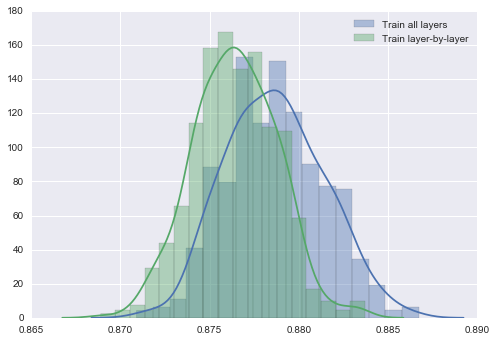

In [18]:
sns.distplot(train3,label="Train all layers")
sns.distplot(train123,label="Train layer-by-layer")
plt.legend()

In [22]:
print("Mean and standard deviation of training all layers: " + str(np.mean(train3)) + ", " + str(np.std(train3)))
print("Mean and standard deviation of layer-wise training: " + str(np.mean(train123)) + ", " + str(np.std(train123)))

Mean and standard deviation of training all layers: 0.87867, 0.00274425
Mean and standard deviation of layer-wise training: 0.876439, 0.00234411
